In [13]:
BLACKHOLE = False


import os
import sys
from pathlib import Path
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # fixes problem with graph


if BLACKHOLE:
    workspace_path = os.path.expandvars('$BLACKHOLE')
    sys.path.append(workspace_path+'/DeepLearning/02456_news_project/src')
    DATAPATH = Path(workspace_path+"/DeepLearning/ebnerd_data").expanduser()
else:
    DATAPATH = Path("~/ebnerd_data").expanduser()

DATASET = "ebnerd_demo"
#DATASET = "ebnerd_small"
#DATASET = "ebnerd_large"

In [14]:
import torch

print("torch version:", torch.__version__)

# Check gpu availability


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Test:
#print(torch.zeros(1).cuda())

torch version: 2.5.1+cu124
cuda


In [ ]:
from utils.data_handler import NewsDataset
import from_ebrec._constants as cs

SEED = 65
HISTORY_SIZE = 50
CANDITATE_SIZE = 5

COLS = [
    cs.DEFAULT_USER_COL,
    cs.DEFAULT_IMPRESSION_ID_COL,
    cs.DEFAULT_IMPRESSION_TIMESTAMP_COL,
    cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    cs.DEFAULT_CLICKED_ARTICLES_COL,
    cs.DEFAULT_INVIEW_ARTICLES_COL,
]

#FRACTION = 0.001
FRACTION = 0.01
#FRACTION = 0.1
#FRACTION = 1

# test
dataset = NewsDataset()

dataset.setup_df(dataset_path = DATAPATH, datasplit = DATASET, history_size = HISTORY_SIZE, columns = COLS, fraction = FRACTION, seed = SEED, candidate_size=CANDITATE_SIZE)


In [16]:
import transformers as huggingface
from from_ebrec._nlp import get_transformers_word_embeddings
from from_ebrec._polars import concat_str_columns
from from_ebrec._articles import convert_text2encoding_with_transformers
from from_ebrec._articles import create_article_id_to_value_mapping

dataset.setup_articles_data(dataset_path = DATAPATH.joinpath(DATASET))

df_articles = dataset.df_articles

TRANSFORMER_MODEL_NAME = "FacebookAI/xlm-roberta-base"
TEXT_COLUMNS_TO_USE = [cs.DEFAULT_SUBTITLE_COL, cs.DEFAULT_TITLE_COL, cs.DEFAULT_ARTICLE_PUBLISHED_TIMESTAMP_COL]
MAX_TITLE_LENGTH = 30

# LOAD HUGGINGFACE:
transformer_model = huggingface.AutoModel.from_pretrained(TRANSFORMER_MODEL_NAME)
transformer_tokenizer = huggingface.AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)

word2vec_embedding = get_transformers_word_embeddings(transformer_model)
df_articles, cat_cal = concat_str_columns(df_articles, columns=TEXT_COLUMNS_TO_USE)
df_articles, token_col_title = convert_text2encoding_with_transformers(df_articles, transformer_tokenizer, cat_cal, max_length=MAX_TITLE_LENGTH)
article_mapping = create_article_id_to_value_mapping(df=df_articles, value_col=token_col_title)



In [17]:
from nrms import NRMSModel
from hyperparameters import hparams_nrms

hparams = hparams_nrms()

BATCH_SIZE = 64


# PARAMETERS
hparams.title_size = MAX_TITLE_LENGTH
hparams.history_size = HISTORY_SIZE
hparams.batch_size = BATCH_SIZE
hparams.candidate_size = CANDITATE_SIZE

# MODEL ARCHITECTURE
hparams.head_num = 16
hparams.head_dim = 16
hparams.attention_hidden_dim = 200
hparams.linear_hidden_dim = 200
hparams.embedding_dim = word2vec_embedding.shape[1]

hparams.use_positional_encoding = False
hparams.use_learned_positions = False

# MODEL OPTIMIZER:
hparams.optimizer = "adam"
hparams.loss = "mse_loss"
hparams.dropout = 0.2
hparams.learning_rate = 1e-4

model = NRMSModel(hparams=hparams, word2vec_embedding=word2vec_embedding, debug=False)

print(model)


NRMSModel(
  (news_encoder): NewsEncoder(
    (embedding): Embedding(250002, 768)
    (dropout): Dropout(p=0.2, inplace=False)
    (self_attention): SelfAttention(
      (query_proj): Linear(in_features=768, out_features=256, bias=True)
      (key_proj): Linear(in_features=768, out_features=256, bias=True)
      (value_proj): Linear(in_features=768, out_features=256, bias=True)
    )
    (dense_layers): Sequential(
      (0): Linear(in_features=256, out_features=200, bias=True)
      (1): ReLU()
      (2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=200, out_features=200, bias=True)
      (5): ReLU()
      (6): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=200, out_features=256, bias=True)
      (9): ReLU()
      (10): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (11): Dropout(p=0.2, inplace=False)
    )
    (att_

In [18]:
import torch.nn as nn
import torch.optim as optim

# Define the loss function and optimizer
if hparams.loss == "cross_entropy_loss":
    criterion = nn.CrossEntropyLoss() 
elif hparams.loss == "mse_loss":
    criterion = nn.MSELoss()
else:
    raise ValueError(f"Loss function {hparams.loss} not supported")

if hparams.optimizer == "adam":
    optimizer = optim.Adam(model.parameters(), lr=hparams_nrms.learning_rate)
else:
    raise ValueError(f"Optimizer {hparams.optimizer} not supported")

In [19]:
from dataloader import NRMSDataLoader


train_dataloader = NRMSDataLoader(
    behaviors= dataset.df_train,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column= cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    batch_size=BATCH_SIZE,
)
val_dataloader = NRMSDataLoader(
    behaviors= dataset.df_validation,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column= cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    batch_size=BATCH_SIZE,
)

In [20]:
# Train the model 

EPOCHS = 10

# Move model to GPU if available
model.to(device)

# Training loop
train_loss_history, val_loss_history = [], []

for epoch in range(EPOCHS):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    first_batch = True
    for iteration, (data, labels) in enumerate(train_dataloader):
        # Unpacking of batch
        his_input_title, pred_input_title = data


        # Move data to device
        his_input_title = his_input_title.to(device)
        pred_input_title = pred_input_title.to(device)

        labels = labels.to(device)

        # Forward pass
        outputs = model(pred_input_title, his_input_title)  
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        print(f"Epoch {epoch + 1}/{EPOCHS}, Train iteration {iteration + 1}/{len(train_dataloader)}: Loss = {loss.item():.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for iteration, (data, labels) in enumerate(val_dataloader):
            his_input_title, pred_input_title = data

            his_input_title = his_input_title.to(device)
            pred_input_title = pred_input_title.to(device)
            labels = labels.to(device)

            outputs = model(pred_input_title, his_input_title)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()

            print(f"Epoch {epoch + 1}/{EPOCHS}, Val iteration {iteration + 1}/{len(val_dataloader)}: Loss = {loss.item():.4f}")

    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    print(f"Epoch {epoch + 1}/{EPOCHS}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


Epoch 1/10, Train iteration 1/4: Loss = 0.1223
Epoch 1/10, Train iteration 2/4: Loss = 0.1224
Epoch 1/10, Train iteration 3/4: Loss = 0.1225
Epoch 1/10, Train iteration 4/4: Loss = 0.1225
Epoch 1/10, Val iteration 1/1: Loss = 0.1221
Epoch 1/10: Train Loss = 0.1224, Val Loss = 0.1221
Epoch 2/10, Train iteration 1/4: Loss = 0.1219
Epoch 2/10, Train iteration 2/4: Loss = 0.1223
Epoch 2/10, Train iteration 3/4: Loss = 0.1222
Epoch 2/10, Train iteration 4/4: Loss = 0.1222
Epoch 2/10, Val iteration 1/1: Loss = 0.1220
Epoch 2/10: Train Loss = 0.1221, Val Loss = 0.1220
Epoch 3/10, Train iteration 1/4: Loss = 0.1218
Epoch 3/10, Train iteration 2/4: Loss = 0.1219
Epoch 3/10, Train iteration 3/4: Loss = 0.1218
Epoch 3/10, Train iteration 4/4: Loss = 0.1216
Epoch 3/10, Val iteration 1/1: Loss = 0.1220
Epoch 3/10: Train Loss = 0.1218, Val Loss = 0.1220
Epoch 4/10, Train iteration 1/4: Loss = 0.1215
Epoch 4/10, Train iteration 2/4: Loss = 0.1216
Epoch 4/10, Train iteration 3/4: Loss = 0.1212
Epoch 4

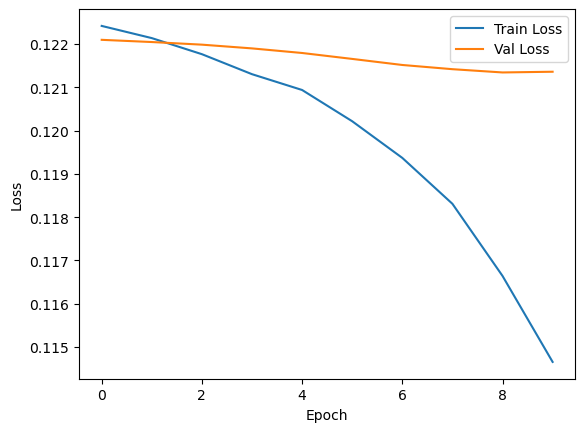

In [21]:
# Plot the loss history
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [22]:
# Evaluate the model
BATCH_SIZE_TEST = 10

dataset.setup_test_data(dataset_path = DATAPATH, datasplit = DATASET, history_size = HISTORY_SIZE, columns = COLS, fraction = FRACTION, seed = SEED, candidate_size=CANDITATE_SIZE)

test_dataloader = NRMSDataLoader(
    behaviors=dataset.df_test,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column=cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    batch_size=BATCH_SIZE_TEST,
)

model.eval()

test_loss = 0.0
pred_test = []
labels_test = []
with torch.no_grad():  
    for iteration, (data, labels) in enumerate(test_dataloader):
        his_input_title, pred_input_title = data

        his_input_title = his_input_title.to(device)
        pred_input_title = pred_input_title.to(device)
        labels = labels.to(device)

        outputs = model(pred_input_title, his_input_title) 
        loss = criterion(outputs, labels)                 
        test_loss += loss.item()

        for i in range(outputs.size(0)):
            pred_test.append(outputs[i].tolist())
            labels_test.append(labels[i].tolist())

        print(f"Test Batch {iteration + 1}/{len(test_dataloader)}: Loss = {loss.item():.4f}")

    test_loss /= len(test_dataloader)
    print("Test loss:", test_loss)
        
print(pred_test)
print(labels_test)

from from_ebrec.evaluation import MetricEvaluator
from from_ebrec.evaluation import AucScore, MrrScore, NdcgScore
metrics = MetricEvaluator(
    labels = labels_test,
    predictions= pred_test,
    metric_functions=[AucScore(), MrrScore(), NdcgScore(k=5), NdcgScore(k=10)],
)
metrics.evaluate()
print(metrics)



Test Batch 1/26: Loss = 0.1263
Test Batch 2/26: Loss = 0.1220
Test Batch 3/26: Loss = 0.1216
Test Batch 4/26: Loss = 0.1249
Test Batch 5/26: Loss = 0.1220
Test Batch 6/26: Loss = 0.1205
Test Batch 7/26: Loss = 0.1255
Test Batch 8/26: Loss = 0.1225
Test Batch 9/26: Loss = 0.1242
Test Batch 10/26: Loss = 0.1225
Test Batch 11/26: Loss = 0.1222
Test Batch 12/26: Loss = 0.1236
Test Batch 13/26: Loss = 0.1240
Test Batch 14/26: Loss = 0.1245
Test Batch 15/26: Loss = 0.1218
Test Batch 16/26: Loss = 0.1236
Test Batch 17/26: Loss = 0.1244
Test Batch 18/26: Loss = 0.1211
Test Batch 19/26: Loss = 0.1217
Test Batch 20/26: Loss = 0.1189
Test Batch 21/26: Loss = 0.1209
Test Batch 22/26: Loss = 0.1255
Test Batch 23/26: Loss = 0.1242
Test Batch 24/26: Loss = 0.1164
Test Batch 25/26: Loss = 0.1238
Test Batch 26/26: Loss = 0.1196
Test loss: 0.1226198383821891
[[0.14154665172100067, 0.10945907980203629, 0.16272781789302826, 0.1256328523159027, 0.16272781789302826, 0.18911884725093842, 0.10878696292638779]

AUC: 100%|█████████████████████████████████| 255/255 [00:00<00:00, 36319.87it/s]

<MetricEvaluator class>: 
 {
    "auc": 0.5196078431372549,
    "mrr": 0.40090569561157796,
    "ndcg@5": 0.4540741248539511,
    "ndcg@10": 0.5426808707290175
}


In [23]:
number_to_print = 20
print("Top %d predictions vs labels:" % number_to_print)
labels = dataset.df_test["labels"].to_list()
for i in range(number_to_print):
    print(f"Article {i}")
    for j in range(len(pred_test[i])):
        print(f"{pred_test[i][j]:.3f} vs {labels[i][j]:.3f}")
    print("")





Top 20 predictions vs labels:
Article 0
0.142 vs 0.000
0.109 vs 0.000
0.163 vs 0.000
0.126 vs 1.000
0.163 vs 0.000
0.189 vs 0.000
0.109 vs 0.000

Article 1
0.148 vs 1.000
0.142 vs 0.000
0.176 vs 0.000
0.142 vs 0.000
0.133 vs 0.000
0.133 vs 0.000
0.125 vs 0.000

Article 2
0.165 vs 0.000
0.165 vs 0.000
0.129 vs 1.000
0.130 vs 0.000
0.151 vs 0.000
0.130 vs 0.000
0.130 vs 0.000

Article 3
0.158 vs 0.000
0.143 vs 0.000
0.143 vs 0.000
0.119 vs 0.000
0.135 vs 0.000
0.183 vs 1.000
0.119 vs 0.000

Article 4
0.156 vs 0.000
0.159 vs 0.000
0.113 vs 0.000
0.124 vs 1.000
0.113 vs 0.000
0.159 vs 0.000
0.176 vs 0.000

Article 5
0.198 vs 0.000
0.131 vs 0.000
0.107 vs 0.000
0.236 vs 0.000
0.122 vs 1.000
0.131 vs 0.000
0.075 vs 0.000

Article 6
0.195 vs 0.000
0.152 vs 0.000
0.121 vs 0.000
0.060 vs 1.000
0.152 vs 0.000
0.195 vs 0.000
0.126 vs 0.000

Article 7
0.035 vs 0.000
0.181 vs 1.000
0.170 vs 0.000
0.117 vs 0.000
0.117 vs 0.000
0.190 vs 0.000
0.190 vs 0.000

Article 8
0.134 vs 1.000
0.108 vs 0.000
0.

Confusion Matrix:
[[1530    0]
 [ 255    0]]


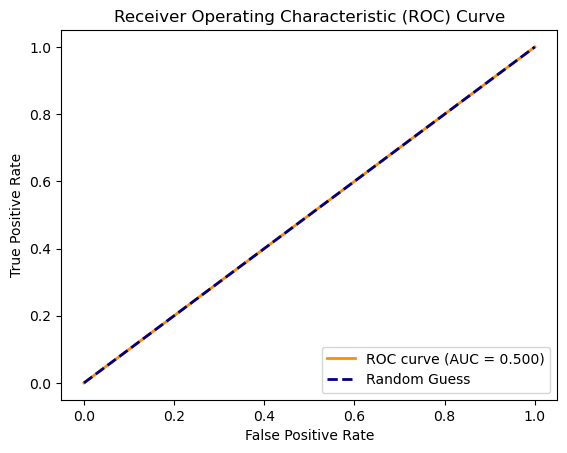

In [25]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt


# Flatten the data for analysis
predicted_probabilities = [prob for article in pred_test for prob in article]
true_values = [val for article in labels[:len(pred_test)] for val in article]


# Set a threshold (commonly 0.5) to classify probabilities as 0 or 1
threshold = 0.5
predicted_classes = [1 if p >= threshold else 0 for p in predicted_probabilities]

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_values, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate AUC and ROC curve
fpr, tpr, thresholds = roc_curve(true_values, predicted_classes)
roc_auc = auc(fpr, tpr)

# Plot ROC curve with AUC value explicitly highlighted
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()